# Refactorización del Approach del Problema a Abordar

Debido a las similitudes entre los problemas que los grupos abordaron en la sección, se tomo la decisión de cambiar el aproach del problema. Enfocándonos en lo que es el ajuste de precios de productos en base a distintas variables que puedan tener influencia significativa en esto. Para lograr esto de una manera eficiente se realizará un análisis a profundidad que nos a ayude a comprender de mejor manera esto para mostrar resultados y recomendaciones relevantes.

### Objetivo

El objetivo del modelo es predecir un precio óptimo en funciónd e las características del producto, ubicación del ccliente, tipo de cliente y pago, comportamiento y satisfacción y tiempos de entrega

### Variables en consideración

Las variables que se tienen a disponibles para realizar este análisis son product_category_name_english product_weight_g, product_photos_qty, product_name_lenght, product_description_lenght, customer_city, customer_state, payment_type, payment_value, payment_installments, seller_city, seller_state, freight_value, order_estimated_delivery_date, order_delivered_customer_date, review_score y order_purchase_timestamp. Pero primero realizaremos una matriz de correlación para validarlo.

### Matriz de correlación
Se realizará una matriz de correlación para poder identificar qué variables númericas impactan más nuestra variable objetivo, price. 

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\alambre1\AppData\Local\Temp\ipykernel_12616\2957902576.py:5: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv("..\data_clean\olist_dataset_unificado_clean.csv", parse_dates=[


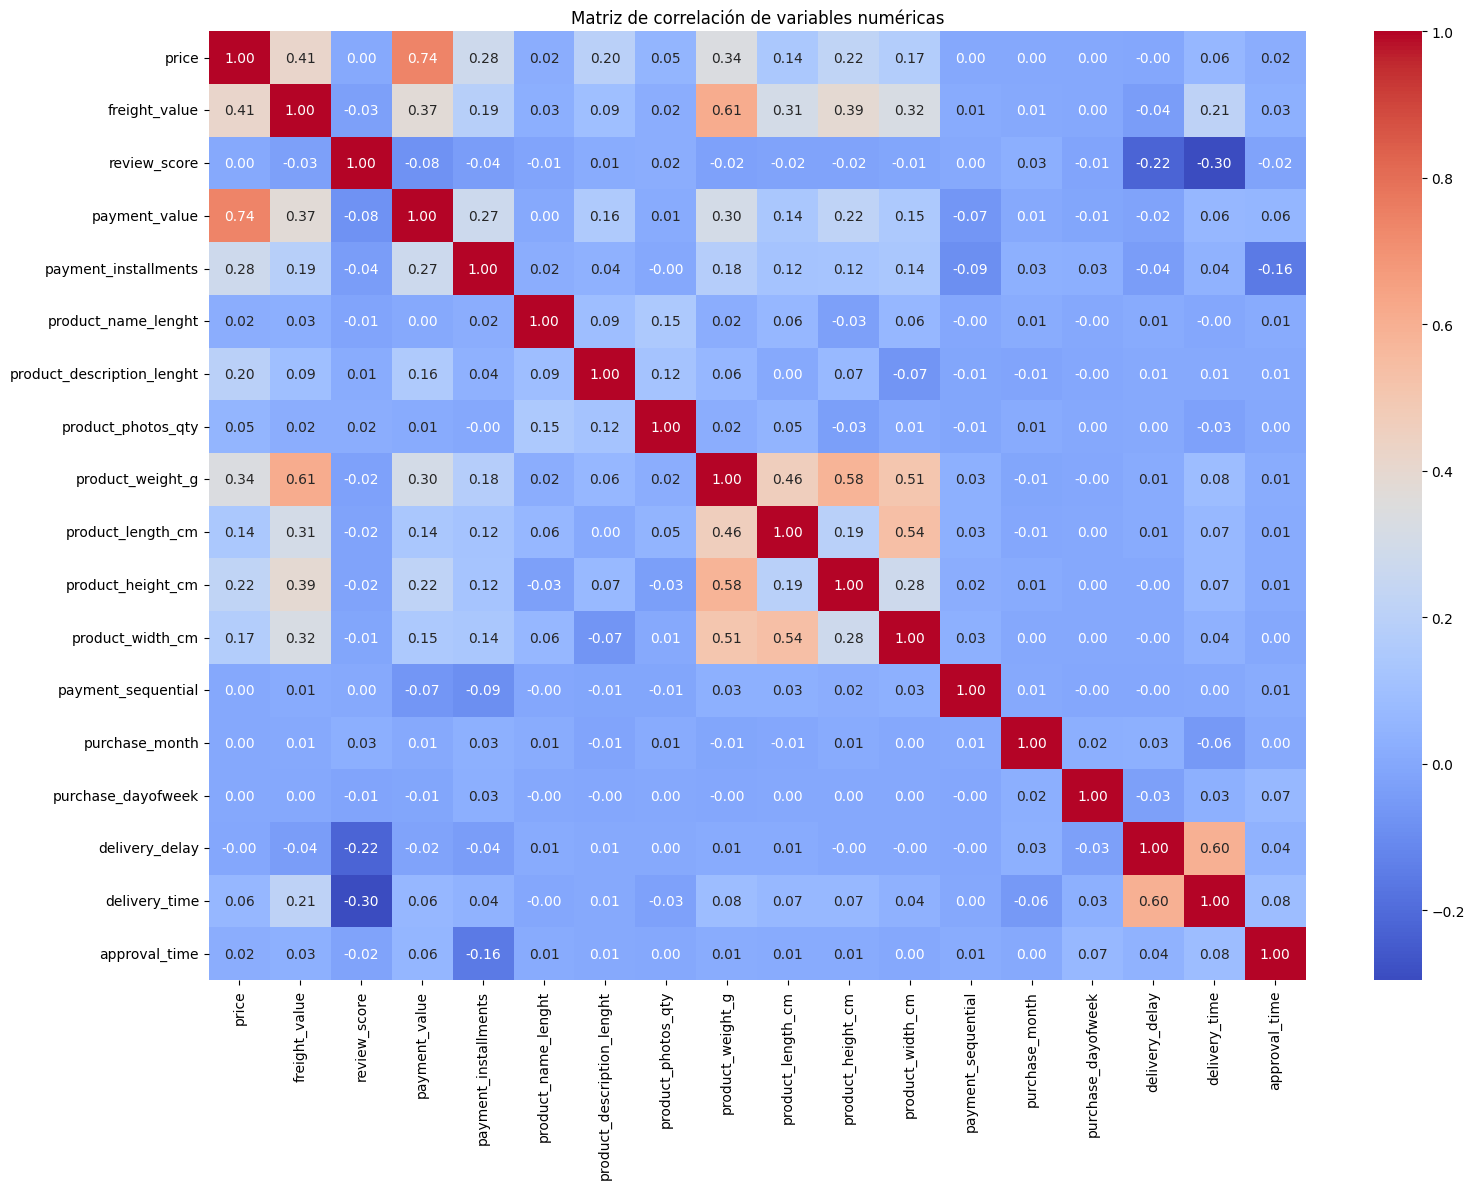

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("..\data_clean\olist_dataset_unificado_clean.csv", parse_dates=[
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "review_creation_date",
    "review_answer_timestamp"
])

# === FEATURES TEMPORALES ===
df["purchase_month"] = df["order_purchase_timestamp"].dt.month
df["purchase_dayofweek"] = df["order_purchase_timestamp"].dt.dayofweek
df["delivery_delay"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.days
df["delivery_time"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
df["approval_time"] = (df["order_approved_at"] - df["order_purchase_timestamp"]).dt.total_seconds() / 3600

# === FILTRO DE VARIABLES NUMÉRICAS ===
numericas = [
    "price", "freight_value", "review_score", "payment_value", "payment_installments",
    "product_name_lenght", "product_description_lenght", "product_photos_qty",
    "product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm",
    "payment_sequential", "purchase_month", "purchase_dayofweek",
    "delivery_delay", "delivery_time", "approval_time"
]
df_numerico = df[numericas].dropna()
corr = df_numerico.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación de variables numéricas")
plt.tight_layout()
plt.show()

In [ ]:
categoricas = [
    "customer_state", "seller_state", "payment_type", "product_category_name_english"
]

df_modelo = df[categoricas + numericas].dropna()
df_codificado = pd.get_dummies(df_modelo, drop_first=True)
corr_codificado = df_codificado.corr()
corr_price = corr_codificado["price"].sort_values(ascending=False)
print(corr_price.head(20))


price                                                                  1.000000
payment_value                                                          0.737532
freight_value                                                          0.414298
product_weight_g                                                       0.338484
payment_installments                                                   0.277701
product_category_name_english_computers                                0.233039
product_height_cm                                                      0.222752
product_description_lenght                                             0.199166
product_width_cm                                                       0.172951
seller_state_BA                                                        0.143472
product_length_cm                                                      0.142693
product_category_name_english_watches_gifts                            0.103054
product_category_name_english_home_appli

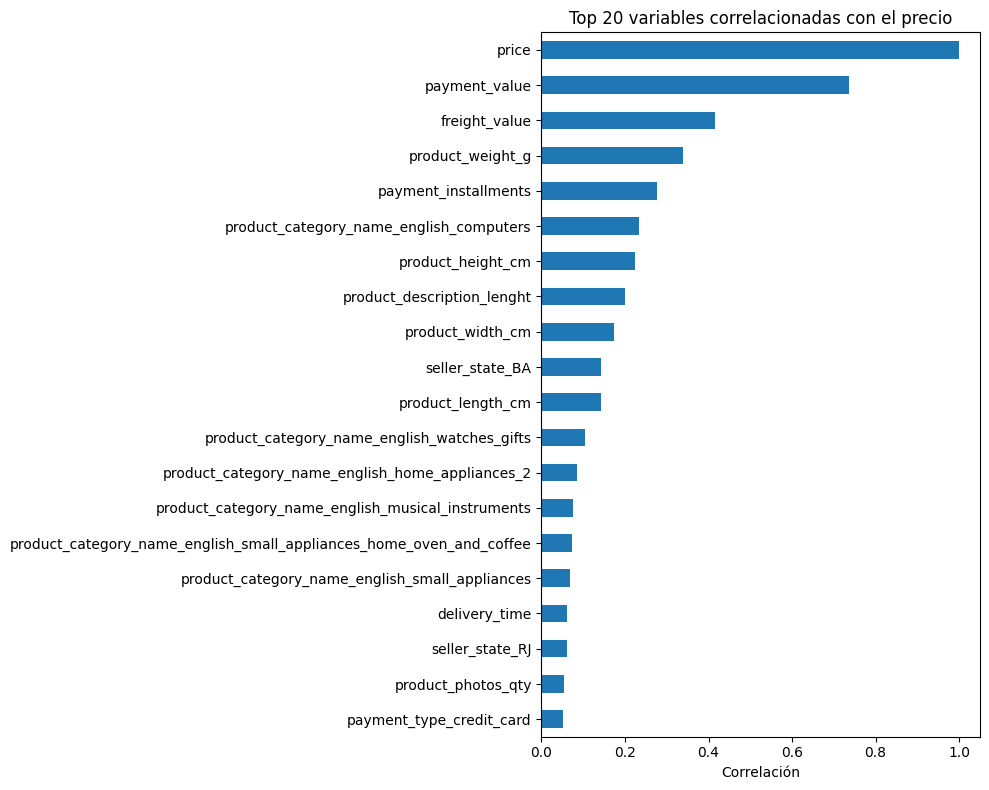

In [4]:
# Graficar top 20
corr_price.head(20).plot(kind='barh', figsize=(10, 8), title='Top 20 variables correlacionadas con el precio')
plt.xlabel("Correlación")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


En base a este análisis se pueden observar que las variables payment_value, freight_value, product_weight_g, payment_installments reflejan los componentes del costo y por lo tanto estan altamente correlacionadas con el precio. también es importante mencionar que algunas categorías como computers, watches gifrs, home appliances y musical instruments suelen tener precios más altos.

### Implementación de Modelos de Regresión

Luego de identificar las variables relevantes identficadas se utilizarán dos modelos de regresión: RandomForestRegresor para realizar la interpretación y precisión y XGBoost para un rendimiento más afinado.


Resultados del modelo:
                         MAE        RMSE        R2
Linear Regression  52.357620  120.183783  0.602291
Random Forest      15.217654   55.169541  0.916195
XGBoost            26.024157   72.338701  0.855916


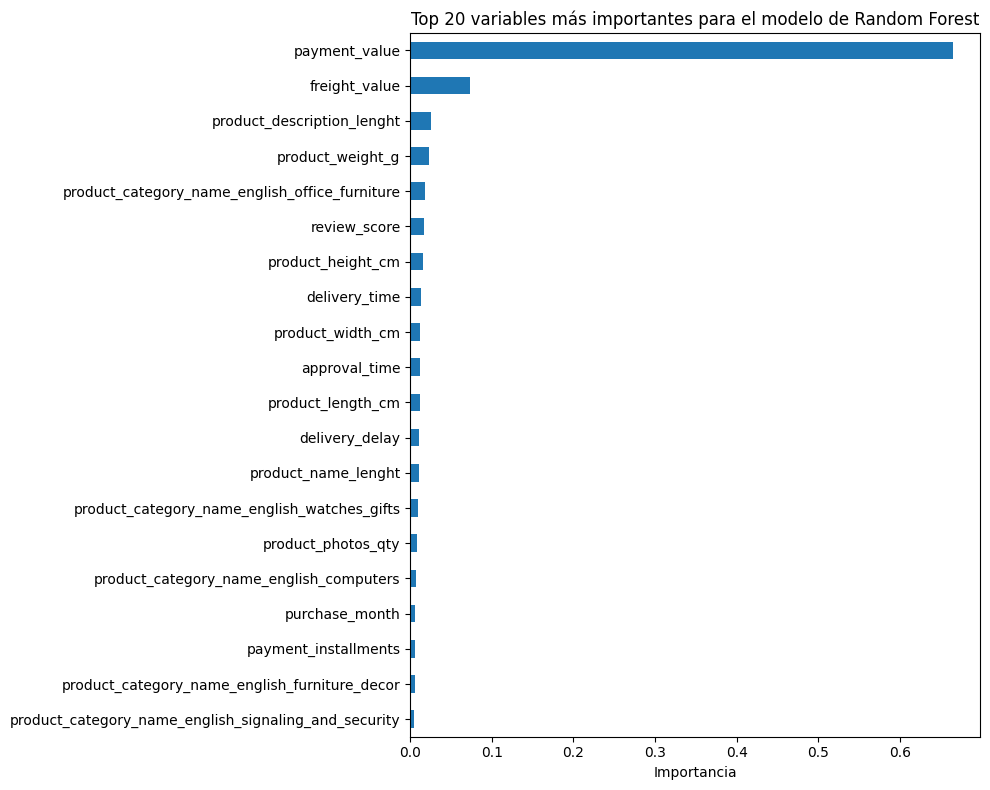

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

columnas_utiles = numericas + categoricas + ["price"]
df_filtrado = df[columnas_utiles].dropna()

df_dummies = pd.get_dummies(df_filtrado, columns=categoricas, drop_first=True)

X = df_dummies.drop("price", axis=1)
y = df_dummies["price"]

# Convertir a float32 para evitar errores con XGBoost
X = X.astype("float32")
y = y.astype("float32")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Modelos a utilizar
modelos = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}
resultados = {}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    resultados[nombre] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

resultados_df = pd.DataFrame(resultados).T
print("\nResultados del modelo:")
print(resultados_df)

#Random Forest
modelo_arbol = modelos["Random Forest"]
importancias = pd.Series(modelo_arbol.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
importancias.head(20).plot(kind="barh")
plt.title("Top 20 variables más importantes para el modelo de Random Forest")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Random Forest muestra que las variables dominantes son payment_value y freight_value. Asimismo, es importante mencionar que algunas carácterísticas físicas como product_weight_g y description_length tambien son importantes.

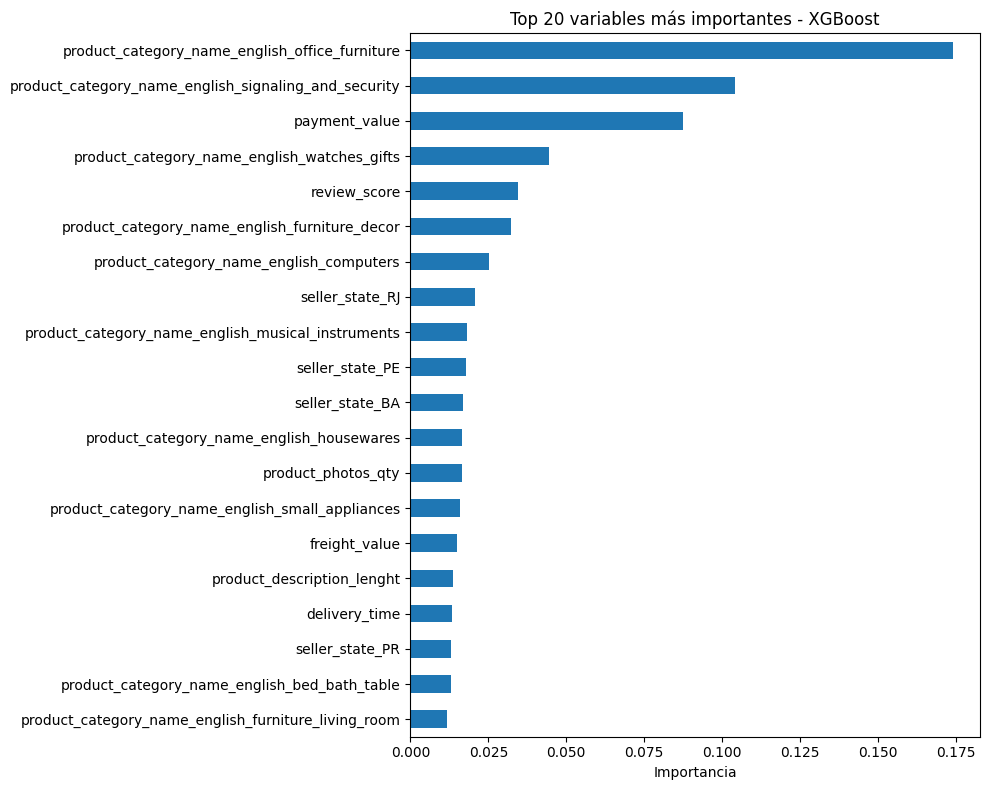

In [12]:
modelo_xgb = modelos["XGBoost"]
importancias_xgb = pd.Series(modelo_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
importancias_xgb.head(20).plot(kind="barh")
plt.title("Top 20 variables más importantes - XGBoost")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


XGBoost muestra mucho peso en lo que son las categorías del producto como office_furniture_signaling_and_security y la ubicación del vendedor seller_state_* que más adelante nos puede ayudar en la diferenciación de precios en base a las categorías y regiones.

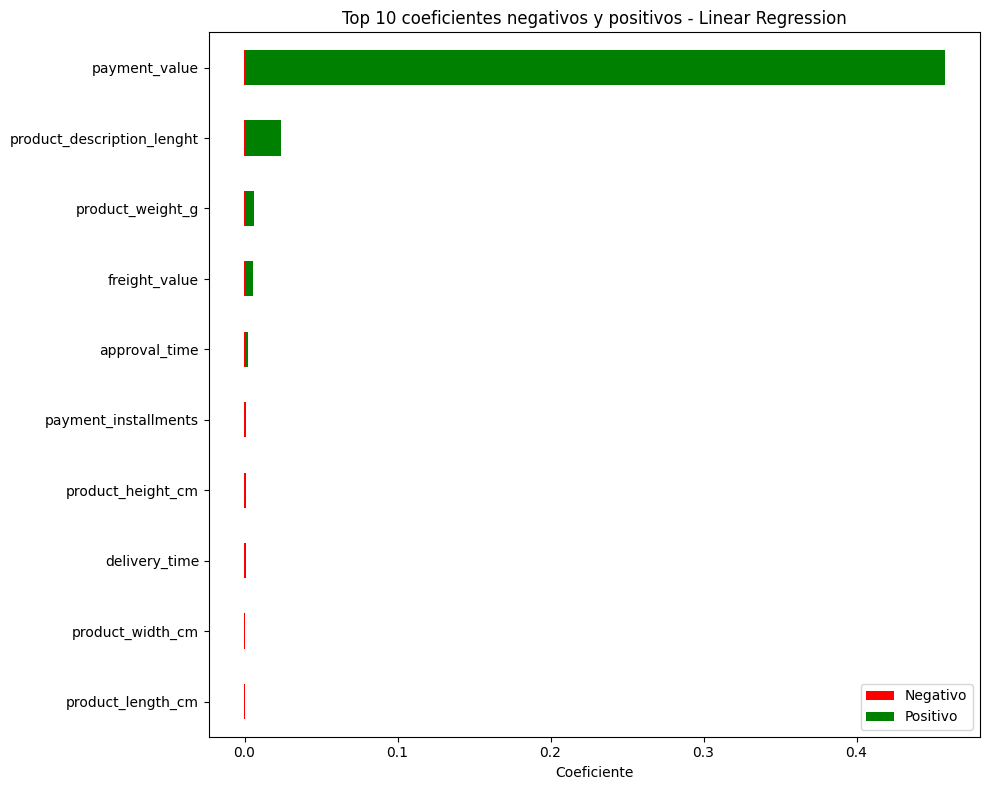

In [13]:
modelo_lr = modelos["Linear Regression"]
coeficientes = pd.Series(modelo_lr.coef_, index=X.columns).sort_values()

plt.figure(figsize=(10, 8))
coeficientes.head(10).plot(kind="barh", color="red", label="Negativo")
coeficientes.tail(10).plot(kind="barh", color="green", label="Positivo")
plt.title("Top 10 coeficientes negativos y positivos - Linear Regression")
plt.xlabel("Coeficiente")
plt.legend()
plt.tight_layout()
plt.show()

Linea regresión muestra una gran dependencia de lo que es paymente_value y description_length.En base a los resultados obtenidos podemos observar que Linear Regression mostró un subjauste notable. Random Forest muestra un muy buen desempeño y un error bastante bajo. XGBoost también mostró un desempeño bastante fuerte y levemente inferior a Random Forest.